# Data Visualization
# Investigation Precipitation and Temperatre Anomalies

* This script investigates the precipitation and temperature data
* Precipitation and temperature data are uploaded to github repository

* This is modelled after Lesson 10 Time Series

In [1]:
# import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

import geopandas as gpd
from shapely.geometry import Point, Polygon

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

## Precipitation Anomalies

In [2]:
# import data
# source: https://data.gov.in/catalog/rainfall-india?filters%5Bfield_catalog_reference%5D=1090541&format=json&offset=0&limit=6&sort%5Bcreated%5D=desc
import os
os.chdir(r'C:\\Users\\livsh\\Downloads') 
precip = pd.read_csv('monthly precipitation.csv')

**Data Background**
The temperature data is in the form of temperature anomalies (differences from the mean/average value) per month and per season (DJF=Dec-Feb, MAM=Mar-May, etc). We won't be working with absolute temperature data since anomalies are more important than absolute temperature in climate change investigations. A positive anomaly value means that the observed precipitation was greater than the baseline average and a negative anomaly value means that it was less than the baseline average.

In [3]:
precip = precip[(precip['SUBDIVISION']  == 'East Rajasthan')]
len(precip)

117

In [4]:
precip.head()

,SUBDIVISION,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL,JF,MAM,JJAS,OND
1966,East Rajasthan,1901,21.6,8.9,2.9,0.7,5.0,15.0,164.8,175.6,7.5,9.8,0.0,0.8,412.5,30.5,8.5,362.9,10.6
1967,East Rajasthan,1902,4.1,0.7,0.0,1.8,9.9,34.6,247.6,116.7,145.6,14.4,0.0,2.8,578.3,4.8,11.7,544.5,17.2
1968,East Rajasthan,1903,1.9,0.7,1.3,0.1,12.9,15.6,238.2,229.1,168.5,17.8,0.0,0.0,686.1,2.7,14.2,651.4,17.8
1969,East Rajasthan,1904,4.3,5.5,21.7,0.2,27.5,49.9,289.7,223.5,50.2,1.5,5.8,14.7,694.5,9.8,49.4,613.3,22.0
1970,East Rajasthan,1905,4.1,8.8,3.2,1.6,2.0,14.4,130.5,30.9,83.8,0.0,0.0,0.6,279.8,12.8,6.8,259.6,0.6


In [5]:
# reset index so it is easier to keep track of years/ index
precip = precip.dropna(axis=0, how = 'any') 
precip.reset_index(inplace = True)
print(len(precip))
precip.head()

117


,index,SUBDIVISION,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL,JF,MAM,JJAS,OND
0,1966,East Rajasthan,1901,21.6,8.9,2.9,0.7,5.0,15.0,164.8,175.6,7.5,9.8,0.0,0.8,412.5,30.5,8.5,362.9,10.6
1,1967,East Rajasthan,1902,4.1,0.7,0.0,1.8,9.9,34.6,247.6,116.7,145.6,14.4,0.0,2.8,578.3,4.8,11.7,544.5,17.2
2,1968,East Rajasthan,1903,1.9,0.7,1.3,0.1,12.9,15.6,238.2,229.1,168.5,17.8,0.0,0.0,686.1,2.7,14.2,651.4,17.8
3,1969,East Rajasthan,1904,4.3,5.5,21.7,0.2,27.5,49.9,289.7,223.5,50.2,1.5,5.8,14.7,694.5,9.8,49.4,613.3,22.0
4,1970,East Rajasthan,1905,4.1,8.8,3.2,1.6,2.0,14.4,130.5,30.9,83.8,0.0,0.0,0.6,279.8,12.8,6.8,259.6,0.6


In [6]:
precip.isna().sum() 
# all 0's for each column - so no data is missing

index          0
SUBDIVISION    0
YEAR           0
JAN            0
FEB            0
MAR            0
APR            0
MAY            0
JUN            0
JUL            0
AUG            0
SEP            0
OCT            0
NOV            0
DEC            0
ANNUAL         0
JF             0
MAM            0
JJAS           0
OND            0
dtype: int64

In [7]:
describe = precip.describe().T
describe

,count,mean,std,min,25%,50%,75%,max
index,117.0,2024.000000,33.919021,1966.0,1995.0,2024.0,2053.0,2082.0
YEAR,117.0,1959.000000,33.919021,1901.0,1930.0,1959.0,1988.0,2017.0
JAN,117.0,6.389744,8.172530,0.0,0.7,3.6,8.6,39.2
FEB,117.0,5.328205,7.436592,0.0,0.4,2.2,8.5,35.7
MAR,117.0,4.518803,9.067353,0.0,0.2,1.4,4.1,57.4
APR,117.0,3.096581,5.898582,0.0,0.2,1.0,3.1,43.2
MAY,117.0,9.862393,12.160236,0.0,2.6,5.7,12.7,90.9
JUN,117.0,63.611111,42.703270,5.1,30.8,53.4,89.9,209.1
JUL,117.0,224.824786,84.291405,13.5,164.8,227.8,288.8,440.6
AUG,117.0,219.015385,95.187826,30.9,142.8,223.1,283.7,435.8


### DataTime Index
* Create empty dataframe with a DateTime index of monthly frequency and then populate this dataframe using the raw data
* Empty dataframe range from January 1901 to December 2017

In [8]:
# Make a new dataframe with an index for each month
# first create the date range
date_rng = pd.date_range(start='1/1/1901', end='1/1/2018', freq='M')

type(date_rng[0])
### returns 
### pandas._libs.tslibs.timestamps.Timestamp

# then, create the empty DataFrame, which we will populate using the raw data
p = pd.DataFrame(date_rng, columns=['date'])

# Create a column for the anomoly values
p['Avg_Anomaly_mm'] = None

# Set the index of the DataFrame to the date column (DateTime index)
p.set_index('date', inplace=True)

# Show the first few elements
p.head()

# using the last day of each month for the indexes bc we only care about the month

,Avg_Anomaly_mm
date,
1901-01-31,None
1901-02-28,None
1901-03-31,None
1901-04-30,None
1901-05-31,None


### Time series manipulation and dealing with missing values

In [9]:
# select only the data that we want - which is the year column and the month columns, leaving out the season columns
precip = precip.iloc[:, 2:15]
precip.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1901,21.6,8.9,2.9,0.7,5.0,15.0,164.8,175.6,7.5,9.8,0.0,0.8
1,1902,4.1,0.7,0.0,1.8,9.9,34.6,247.6,116.7,145.6,14.4,0.0,2.8
2,1903,1.9,0.7,1.3,0.1,12.9,15.6,238.2,229.1,168.5,17.8,0.0,0.0
3,1904,4.3,5.5,21.7,0.2,27.5,49.9,289.7,223.5,50.2,1.5,5.8,14.7
4,1905,4.1,8.8,3.2,1.6,2.0,14.4,130.5,30.9,83.8,0.0,0.0,0.6


In [15]:
# apply Panda's function to move through the rows of the raw data (axis =0 for columns, 1 for rows)
# also need to important the datetime and calendar libraries that we are going to use


# Import needed libraries
import calendar
from datetime import datetime

# define function 
def pop_df_with_anomolies_from_row(row):
    year = row['YEAR']
    # anomaly values (appear to be mixture of strings + floats)
    monthly_anomolies = row.iloc[1:]
    # abbreviated month names (index names)
    months = monthly_anomolies.index
    for month in monthly_anomolies.index:
        # get the last day for each month 
        last_day = calendar.monthrange(year,datetime.strptime(month, '%b').month)[1]
        # construct the index with which we can reference our new DataFrame (to populate) 
        date_index = datetime.strptime(f'{year} {month} {last_day}', '%Y %b %d')
        # populate / set value @ above index, to anomaly value
        p.loc[date_index] = monthly_anomolies[month]

# apply function to each row of raw data 
_ = precip.apply(lambda row: pop_df_with_anomolies_from_row(row), axis=1)

# Show the first few elements of our newly populated DataFrame
print(p)

TypeError: ('integer argument expected, got float', 'occurred at index 0')

In [ ]:
# no need to clean anonmaly values since there were no NaN

### Plot the time series

In [21]:
# Plot the data

# import Matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

# create figure, title and plot data
plt.figure(figsize=(10,8))
plt.xlabel('Time')
plt.ylabel('Precipitation Anomaly (mm)')
plt.plot(p, color='blue', linewidth=1.0)';

SyntaxError: EOL while scanning string literal (<ipython-input-21-860922c46787>, line 12)

* as we move forward in time, ********
* above is granualar data - there is a lot of variation and fluctuation

### Resampling at a different frequency
* the plot above seems messy in a sense that it covers such a logn time span with data that is quite granualar
* the visualization includes a lot of variation
* change the frequency from months to years

In [18]:
p.resample('A').mean().head()   
# trying to remove fluctuations
# takign the average value (mean)
# A represents the year calendar end

DataError: No numeric types to aggregate

DataError: No numeric types to aggregate

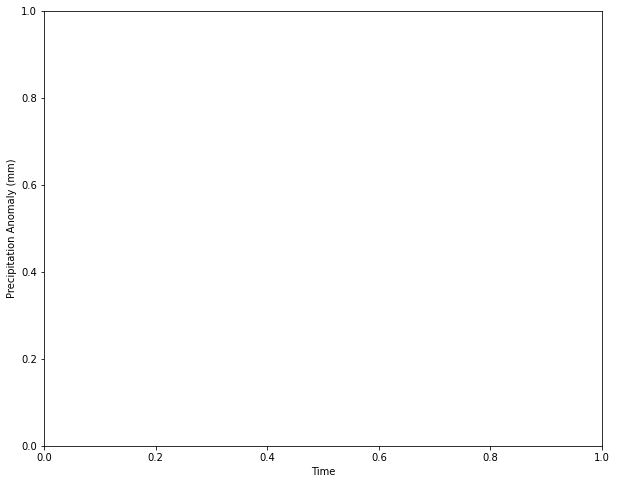

In [22]:
# Visualize the resampled DataFrame

# Create figure, title and plot resampled data
plt.figure(figsize=(10,8))
plt.xlabel('Time')
plt.ylabel('Precipitation Anomaly (mm)')
plt.plot(p.resample('A').mean(), color='blue', linewidth=1.0);

## Temperature Anomalies
* this section will investigate temperature anomalies and create similar visualizations that were created for precipitation anomalies

In [27]:
# import temperature data
# source: https://data.gov.in/resources/monthly-seasonal-and-annual-mean-temp-series-1901-2017
# uploaded temperature data to github

import os
os.chdir(r'C:\\Users\\livsh\\Downloads') 
temp = pd.read_csv('temperature.csv')

In [28]:
temp.head().T

,0,1,2,3,4
YEAR,1901.00,1902.00,1903.00,1904.00,1905.00
JAN,17.99,19.00,18.32,17.77,17.40
FEB,19.43,20.39,19.79,19.39,17.79
MAR,23.49,24.10,22.46,22.95,21.78
APR,26.41,26.54,26.03,26.73,24.84
MAY,28.28,28.68,27.93,27.83,28.32
JUN,28.60,28.44,28.41,27.85,28.69
JUL,27.49,27.29,28.04,26.84,27.67
AUG,26.98,27.05,26.63,26.73,27.47
SEP,26.26,25.95,26.34,25.84,26.29


In [37]:
temp = temp.dropna(axis=0, how = 'any') 
temp.reset_index(inplace = True)
print(len(temp))  # check length of dataframe
temp.head()

116


,index,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,0,1901,17.99,19.43,23.49,26.41,28.28,28.60,27.49,26.98,26.26,25.08,21.73,18.95
1,1,1902,19.00,20.39,24.10,26.54,28.68,28.44,27.29,27.05,25.95,24.37,21.33,18.78
2,2,1903,18.32,19.79,22.46,26.03,27.93,28.41,28.04,26.63,26.34,24.57,20.96,18.29
3,3,1904,17.77,19.39,22.95,26.73,27.83,27.85,26.84,26.73,25.84,24.36,21.07,18.84
4,4,1905,17.40,17.79,21.78,24.84,28.32,28.69,27.67,27.47,26.29,26.16,22.07,18.71


In [38]:
temp.isna().sum() 
# all 0's for each column - so no data is missing

index    0
YEAR     0
JAN      0
FEB      0
MAR      0
APR      0
MAY      0
JUN      0
JUL      0
AUG      0
SEP      0
OCT      0
NOV      0
DEC      0
dtype: int64

In [40]:
describe = temp.describe().T
describe

,count,mean,std,min,25%,50%,75%,max
index,116.0,57.500000,33.630343,0.00,28.7500,57.500,86.2500,115.00
YEAR,116.0,1958.500000,33.630343,1901.00,1929.7500,1958.500,1987.2500,2016.00
JAN,116.0,18.404569,0.581218,17.25,18.0675,18.340,18.7200,20.92
FEB,116.0,20.112586,0.861884,17.79,19.4700,19.985,20.5425,23.58
MAR,116.0,23.415690,0.842945,21.78,22.8325,23.320,23.9150,26.61
APR,116.0,26.491207,0.711790,24.84,25.9900,26.535,26.9025,29.56
MAY,116.0,28.368448,0.617371,26.97,27.9475,28.335,28.7525,30.78
JUN,116.0,28.291121,0.450134,27.33,28.0175,28.250,28.5650,29.88
JUL,116.0,27.361121,0.336064,26.48,27.1500,27.340,27.5150,28.47
AUG,116.0,26.929914,0.332510,26.21,26.7275,26.895,27.1425,28.17


In [29]:
# Make a new dataframe with an index for each month
# first create the date range
date_rng = pd.date_range(start='1/1/1880', end='1/7/2019', freq='M')

type(date_rng[0])
### returns 
### pandas._libs.tslibs.timestamps.Timestamp

# then, create the empty DataFrame, which we will populate using the raw data
t = pd.DataFrame(date_rng, columns=['date'])

# Create a column for the anomoly values
t['Avg_Anomaly_deg_C'] = None

# Set the index of the DataFrame to the date column (DateTime index)
t.set_index('date', inplace=True)

# Show the first few elements
t.head()

# using the last day of each month for the indexes bc we only care about the month

,Avg_Anomaly_deg_C
date,
1880-01-31,None
1880-02-29,None
1880-03-31,None
1880-04-30,None
1880-05-31,None


In [32]:
temp = temp.iloc[:,:13]  # only the rows up to the 13th
temp.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1901,17.99,19.43,23.49,26.41,28.28,28.60,27.49,26.98,26.26,25.08,21.73,18.95
1,1902,19.00,20.39,24.10,26.54,28.68,28.44,27.29,27.05,25.95,24.37,21.33,18.78
2,1903,18.32,19.79,22.46,26.03,27.93,28.41,28.04,26.63,26.34,24.57,20.96,18.29
3,1904,17.77,19.39,22.95,26.73,27.83,27.85,26.84,26.73,25.84,24.36,21.07,18.84
4,1905,17.40,17.79,21.78,24.84,28.32,28.69,27.67,27.47,26.29,26.16,22.07,18.71


In [35]:
# Import needed libraries
import calendar
from datetime import datetime

# define function 
def pop_df_with_anomolies_from_row(row):
    year = row['YEAR']
    # anomaly values (appear to be mixture of strings + floats)
    monthly_anomolies = row.iloc[1:]
    # abbreviated month names (index names)
    months = monthly_anomolies.index
    for month in monthly_anomolies.index:
        # get the last day for each month 
        last_day = calendar.monthrange(year,datetime.strptime(month, '%b').month)[1]
        # construct the index with which we can reference our new DataFrame (to populate) 
        date_index = datetime.strptime(f'{year} {month} {last_day}', '%Y %b %d')
        # populate / set value @ above index, to anomaly value
        t.loc[date_index] = monthly_anomolies[month]

# apply function to each row of raw data 
_ = temp.apply(lambda row: pop_df_with_anomolies_from_row(row), axis=1)

# Show the first few elements of our newly populated DataFrame
print(t)

TypeError: ('integer argument expected, got float', 'occurred at index 0')

In [ ]:
# no need for cleaning up the data since there are no NaN values

#### Plot the data

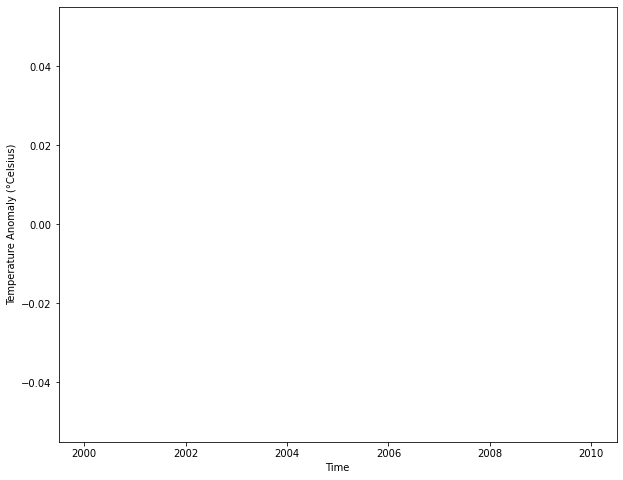

In [42]:
# create figure, title and plot data
plt.figure(figsize=(10,8))
plt.xlabel('Time')
plt.ylabel('Temperature Anomaly (°Celsius)')
plt.plot(t, color='blue', linewidth=1.0);

### Resampling at a different frequency

In [43]:
t.resample('A').mean().head()   
# trying to remove fluctuations
# takign the average value (mean)
# A represents the year calendar end

DataError: No numeric types to aggregate

DataError: No numeric types to aggregate

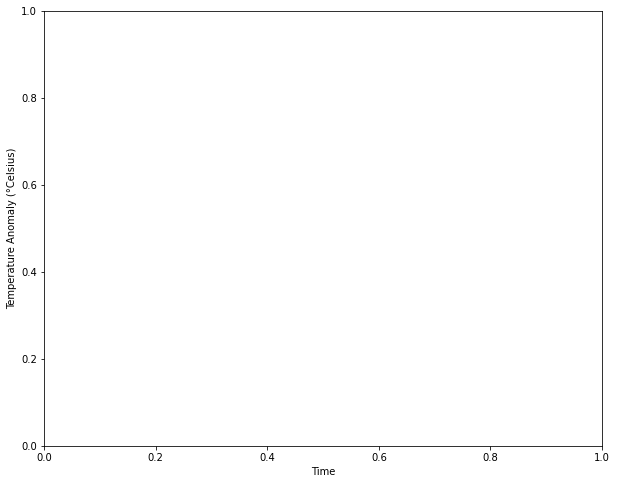

In [44]:
# Visualize our resampled DataFrame

# Create figure, title and plot resampled data
plt.figure(figsize=(10,8))
plt.xlabel('Time')
plt.ylabel('Temperature Anomaly (°Celsius)')
plt.plot(t.resample('A').mean(), color='blue', linewidth=1.0)

## Viszualizing
* since the datasets have been formated, can now plot them 
* will used two libraries to plot the data: Matplotlib and Plotly


### Plotting with Matplotlib

In [45]:
# graph for temperature

# Resample or temperature data to years (end-of-year)
t_resampled = t.resample('A').mean()

# Create figures and axes
fig, ax = plt.subplots(figsize=(10,8))

# Plot temperature data with specific colour and line thickness
ax.plot(t_resampled, color='blue', linewidth=2.5)

# Set axis labels and graph title
ax.set(xlabel='Time (years)', ylabel='Temperature Anomaly (deg. Celsius)',
       title='India Temperature Anomalies from 1901 to 2017')

# set grid
ax.grid()

DataError: No numeric types to aggregate

NameError: name 'e' is not defined

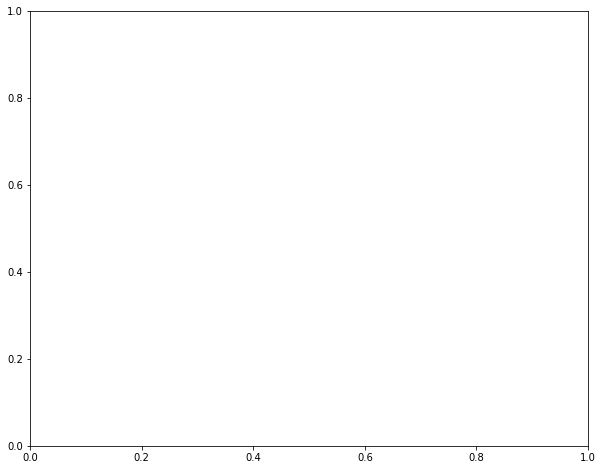

In [46]:
# graph for precipitation

# Create figures and axes
fig, ax = plt.subplots(figsize=(10,8))

# Plot co2 emissions data with specific colour and line thickness
ax.plot(e, color='blue', linewidth=2.5)

# Set axis labels and graph title
ax.set(xlabel='Time (years)', ylabel='Precipitation (mm)',
       title='East Rajasthan Precipitation Anomalies from 1901 to 2017')

# Enable grid
ax.grid()

### Plotting with Plotly
* more visualization of the precipitation and temperature anomalies

In [47]:
# install plotly https://anaconda.org/plotly/plotly
# Standard plotly imports
import plotly.graph_objects as go
from plotly.offline import plot, iplot

In [50]:
# using plotly and cufflinks for create more visualizations
# no importing for cufflinks

# trace for line plot of temp anomalies
trace1 = go.Scatter(
                    x = t_resampled.index,
                    y = t_resampled.Avg_Anomaly_deg_C,
                    mode = "lines",
                    marker = dict(color = 'blue'))

data = [trace1]
layout = dict(title = 'India Temperature Anomalies from 1901 to 2017',
              xaxis= dict(title= 'Time (years)',ticklen= 5,zeroline= False),
              yaxis=dict(title = 'Temperature Anomaly (deg. Celsius)')
             )
fig = dict(data = data, layout = layout)
iplot(fig)

# have temp anomoly and the month and year

NameError: name 't_resampled' is not defined

In [51]:
# trace for line plot of precipitation
trace1 = go.Scatter(
                    x = e.index,
                    y = e.Global_CO2_Emissions_per_Capita,
                    mode = "lines",
                    marker = dict(color = 'blue'))

data = [trace1]
layout = dict(title = 'East Rajasthan Precipitation Anomalies from 1901 to 2017',
              xaxis= dict(title= 'Time (years)',ticklen= 5,zeroline= False),
              yaxis=dict(title = 'Precipitation (mm)')
             )
fig = dict(data = data, layout = layout)
iplot(fig)

NameError: name 'e' is not defined

***
# Time Series Correlation
## Forcasting using Facebook's Prophet
### Creating, fitting, and plotting a model for Temperature

In [52]:
conda install -c conda-forge fbprophet

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [ ]:
# import Facebook's Prophet forecasting library
from fbprophet import Prophet

# create a new DataFrame with which we will create/train our Prophet model 
t_prophet = pd.DataFrame()
t_prophet['ds'] = t.index
t_prophet['y'] = t['Avg_Anomaly_deg_C'].values

# instantiate model and fit to data (just like with sklearn model API)
m = Prophet()
m.fit(t_prophet)

# generate future dataframe containing predictions (this is for 100 years into the future)
future = m.make_future_dataframe(freq='m', periods=100*12)
forecast = m.predict(future)

# plot the resulting forecast
m.plot(forecast);